**Vanessa Navarro Coronado e Iván Sánchez Castellanos**

# Práctica 1 - Preprocesamiento de datos y evaluación de modelos de clasificación/regresión.

A lo largo de esta práctica vamos a realizar un análisis detallado de dos datasets que se nos proporcionaban en el guión de esta práctica. También realizaremos un preprocesamiento de los datos para conseguir un mayor rendimiento en nuestros modelos, y para comprender mejor el proceso de clasificación dentro de estos datasets.

Por último, realizaremos un proceso de entrenamiento y validación de modelos utilizando los clasificadores ZeroR, OneR y un árbol de decisión. 

Primero, importamos las librerías que vamos a usar.

In [1]:
# Always load all scipy stack packages
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

# Misc
import base64

In [2]:
# This code configures matplotlib for proper rendering
%matplotlib inline
mpl.rcParams["figure.figsize"] = "8, 4"
import warnings
warnings.simplefilter("ignore")

Esta variable nos servirá más adelante para realizar nuestros procesos de holdout con una semilla, lo que nos permitirá reproducir nuestros resultados en un futuro.

In [3]:
# En vuestros experimentos usad siempre una semilla, si no nunca los podreis recuperar
seed=6342
np.random.seed(6342) #DECLARARLA AL PRINCIPIO DEL CUADERNO Y BORRAR EL KERNEL

## 1. Análisis exploratorio mediante gráficas y estadísticos. Interpretación de las distribuciones de las variables más relevantes y su relación con la clase. Identificación de anomalías y tratamiento de datos perdidos.

### 1.1. Análisis exploratorio

Primero cargamos nuestras bases de datos: pima (df1) y wisconsin (df2).

In [4]:
# Please update your data path accordingly
df1 = pd.read_csv("../data/pima.csv", dtype={ "label": 'category'})
df2 = pd.read_csv("../data/wisconsin.csv", dtype={ "label": 'category'})

Comprobamos que se han cargado los datasets seleccionando una muestra aleatoria de cada uno de los conjuntos.

In [5]:
# Retrieve a random sample from the dataframe
df1.sample(8)

,preg,plas,pres,skin,insu,mass,pedi,age,label
408,8,100,74,40,215,39.4,0.661,43,tested_positive
722,1,88,78,29,76,32.0,0.365,29,tested_negative
668,4,116,72,12,87,22.1,0.463,37,tested_negative
121,2,108,62,32,56,25.2,0.128,21,tested_negative
239,1,199,76,43,0,42.9,1.394,22,tested_positive
30,7,133,88,15,155,32.4,0.262,37,tested_negative
109,1,119,54,13,50,22.3,0.205,24,tested_negative
675,1,151,60,0,0,26.1,0.179,22,tested_negative


In [6]:
# Retrieve a random sample from the dataframe
df2.sample(8)

,patientId,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses,label
155,156,3,1,1,1,2,1.0,3,1,1,benign
109,110,4,5,5,10,4,10.0,7,5,8,malignant
183,184,9,7,7,5,5,10.0,7,8,3,malignant
258,259,1,4,3,10,4,10.0,5,6,1,malignant
473,474,3,1,1,1,2,1.0,2,1,1,benign
26,27,5,1,1,1,2,1.0,2,1,1,benign
515,516,4,1,1,1,2,3.0,2,1,1,benign
200,201,6,10,7,7,6,NaN,8,10,2,malignant


Visualizamos el tamaño de los datasets: número de casos y número de atributos.

In [7]:
# Number of cases is just the length of the dataframe
print( len(df1) )
print( df1.shape )
print( df1.size ) # multiplcación de filas x columnas

768
(768, 9)
6912


In [8]:
# Number of cases is just the length of the dataframe
print( len(df2) )
print( df2.shape )
print( df2.size ) # multiplcación de filas x columnas

699
(699, 11)
7689


Una vez hecho esto, identificamos los valores de las variables clase en ambos datasets. Como vemos, en ambos datasets la variable clase solo presenta dos posibles valores: en pima los valores de la clase son 'tested_negative' y 'tested_positive', mientras que en wisconsin son 'benign' y 'malignant'.

In [9]:
# We can inspect categorical variables:
df1.label.cat.categories

Index(['tested_negative', 'tested_positive'], dtype='object')

In [10]:
# We can inspect categorical variables:
df2.label.cat.categories

Index(['benign', 'malignant'], dtype='object')

### 1.2. Interpretación de las distribuciones de las variables

Para comprender mejor los atributos de las bases de datos, los visualizamos mediante histogramas en los que representamos cada uno de los atributos y su correspondiente frecuencia de aparición en la base de datos.

In [11]:
def gMultipleHistogram(targetdf):
    # First we remove the class variable
    target_noclass = targetdf.drop('label', 1) #USAR SIEMPRE 'LABEL', PORQUE 'CLASS' ES PALABRA RESERVADA
    # Now we generate the multiple histogram
    g = sns.FacetGrid(pd.melt(target_noclass), col="variable", sharey=False, sharex=False, col_wrap=2)
    g.map(sns.distplot, "value");

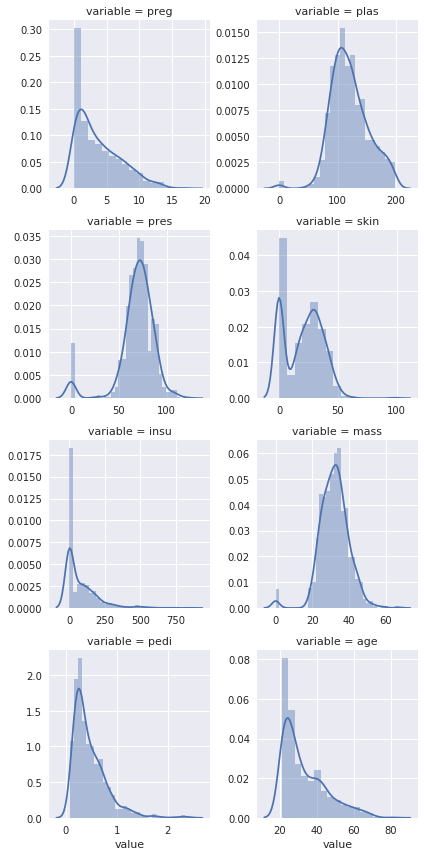

In [12]:
gMultipleHistogram(df1)

En este dataset, observamos que las variables plas, pres y mass tienen una distribución gaussiana, aunque se pueden observar algunos outliers. La variable skin presenta una distribución más compleja, y el resto de variables tienen una distribución con asimetría negativa (right skewed). 

Por ejemplo, en el caso de la variable preg, se observa una gran cantidad de población que no ha estado nunca embarazada, por lo que podríamos pensar que son niños/as, hombres, o simplemente mujeres que nunca han estado embarazadas.

Los valores a cero en algunas de las variables como plas, pres, skin, insu y mass nos pueden hacer pensar que sean valores perdidos, o anómalos. Este asunto lo trataremos más adelante.

En el dataset df2 (wisconsin) tenemos una variable id que no nos aporta nada sobre las demás variables, o sobre la variable clase, ya que cada paciente de la base de datos tendrá un id único, lo que podría sesgar nuestros resultados. Por tanto, prescindimos de ella eliminando la columna 'patientID' de nuestro dataset.

In [13]:
df2_sinId=df2.drop('patientId',1)

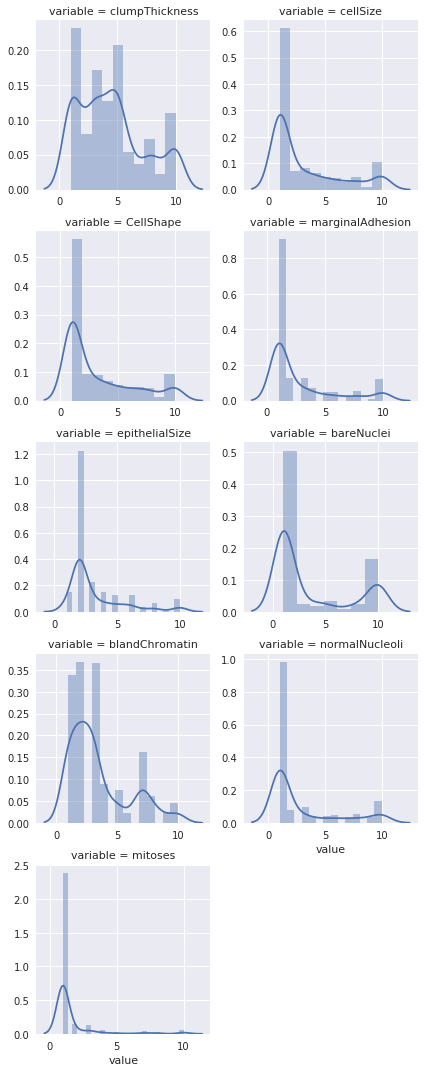

In [14]:
gMultipleHistogram(df2_sinId)

Observando estas distribuciones, vemos que ninguna variable presenta una distribución normal. Esto puede ser debido a la presencia de valores perdidos, como en la variable 'bareNuclei', o valores anómalos, como por ejemplo en las variables 'CellShape' o 'normalNucleoli'.

### 1.3. Estadísticos

En este apartado simplemente calculamos algunos estadísticos para los datasets, que puede que debamos tener en cuenta más adelante a la hora de implementar nuestros clasificadores.

In [15]:
df1.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


Los cuartiles nos pueden servir para visualizar cómo serían los diagramas de cajas de cada una de nuestras variables, y también el rango de valores en los que se encuentran. Esto puede ser de utilidad a la hora de averiguar cuál es la variable más descriptiva en nuestro dataset, o lo que es lo mismo, la variable que más nos ayuda a diferenciar entre una clase u otra a la hora de clasificar los casos.

In [16]:
df2_sinId.describe()

,clumpThickness,cellSize,CellShape,marginalAdhesion,epithelialSize,bareNuclei,blandChromatin,normalNucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,667.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.536732,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.683795,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,7.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Estos estadísticos también nos vendrán bien para realizar el tratamiento de valores perdidos, ya que existen métodos como por ejemplo el de rellenar los valores perdidos con la media, o la moda.

Como vemos, en todos los atributos tenemos un total de 699 casos, excepto en la variable 'bareNuclei', en la que encontramos 667. Esto es debido a la presencia de valores perdidos en este atributo.

### 1.4. La clase

La variable clase es la más importante, ya que esta es la que deberemos predecir ante nuevos casos en nuestra base de datos. Para ver la distribución que presenta la clase, usaremos los diagramas de barras que aparecen a continuación.

In [17]:
def gSingleBarplot(targetDf, targetVar):
    sns.countplot(data=targetDf, x=targetVar)

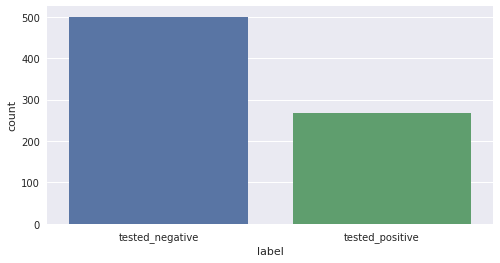

In [18]:
gSingleBarplot(df1, "label") #para ver los 2 estados de la variable categorica

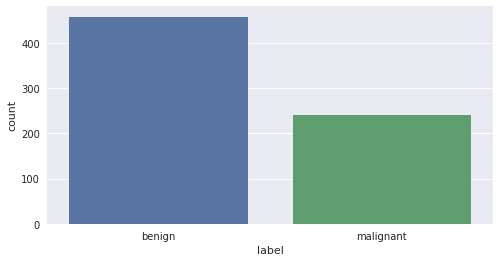

In [19]:
gSingleBarplot(df2, "label") #para ver los 2 estados de la variable categorica

Como vemos, en el dataset pima hay más casos clasificados como 'tested_negative' que como 'tested_positive'. Y lo mismo ocurre con el dataset wisconsin: hay más casos de 'benign' que de 'malignant'.

Por ello, a la hora de realizar las particiones de Train y Test para nuestro proceso de holdout, deberemos tener en cuenta/mantener esta proporción de casos.

### 1.5. Partición de los datasets

Antes de probar los clasificadores y hacer el tratamiento de valores perdidos con nuestros datasets, debemos realizar un proceso de holdout estratificado, en el que haya una parte proporcionada de la base de datos que se utilice para entrenar nuestros clasificadores (Train), y otra parte del dataset que usemos para validar nuestros modelos aprendidos (Test). 

Para ello, lo primero que debemos hacer es desordenar la base de datos usando nuestra semilla (declarada al principio del cuaderno) para que permute los índices de los casos, consiguiendo así una partición balanceada de los casos respecto a su variable clase.

La función train_test_split se encarga de hacer esto, y también de realizar la partición en dos conjuntos Train y Test. Para que esta función consiga realizar la partición adecuadamente, es necesario dividir nuestros datasets en dos partes: por un lado los atributos y por otro las variables clase. También debemos utilizar la semilla que declaramos al principio de este cuaderno, para poder ser capaces de reproducir nuestros resultados en evaluaciones futuras.

La proporcion de casos que usaremos para nuestros conjuntos de Test será de un 40% frente a un 60% de casos para los conjuntos de Train.

In [20]:
# We must always divide our dataset into attributes and label
attributesdf1 = df1.drop('label', 1)
labeldf1 = df1['label']

attributesdf2 = df2_sinId.drop('label', 1)
labeldf2 = df2_sinId['label']

In [21]:
from sklearn.model_selection import train_test_split
train_atts1, test_atts1, train_label1, test_label1 = train_test_split( 
    attributesdf1, # Dataset con los atributos
    labeldf1, # Vector/dataset con la clase
    test_size=0.4, # Proporcion de test
    random_state=seed, # Semilla
    stratify=labeldf1) # Variable a estratificar

In [22]:
from sklearn.model_selection import train_test_split
train_atts2, test_atts2, train_label2, test_label2 = train_test_split( 
    attributesdf2, # Dataset con los atributos
    labeldf2, # Vector/dataset con la clase
    test_size=0.4, # Proporcion de test
    random_state=seed, # Semilla
    stratify=labeldf2) # Variable a estratificar

In [23]:
pimaTraining = train_atts1.assign(label = train_label1)
pimaTest = test_atts1.assign(label = test_label1)

wisconsinTraining = train_atts2.assign(label = train_label2)
wisconsinTest = test_atts2.assign(label = test_label2)

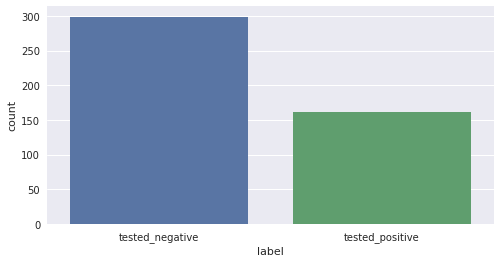

In [24]:
gSingleBarplot(pimaTraining, "label")

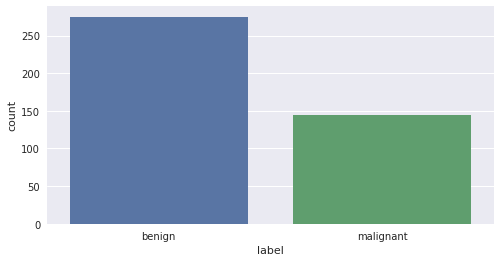

In [25]:
gSingleBarplot(wisconsinTraining, "label")

Como vemos, ambas divisiones de los conjuntos de Train de los datasets pima y wisconsin presentan la misma proporción/distribución que en el dataset original.

### 1.6. Identificación de anomalías y tratamiento de datos perdidos

En el dataset pima, los valores perdidos no se representan con NA o NaN, sino que podrían estar representados con 0. Sin embargo, puede que alguna de las variables tenga este valor dentro de su dominio, por lo que en este caso no sería un valor perdido. 

Para saber si un cero en nuestro dataset es un valor perdido o no, deberíamos consultar con un experto en medicina que conozca las unidades de medida de estas variables, y sus posibles rangos de valores. No obstante, hay algunas variables que tenemos claro que no podrían tener el cero en sus rangos de valores, como por ejemplo el índice de masa corporal (variable 'mass') o la presión sanguínea (variable 'pres'). En estos casos, sí realizaremos un tratamiento de valores perdidos.

Este tratamiento puede hacerse de varias formas:
* Eliminar el caso que contenga valores perdidos: este método sería muy arriesgado ya que, si hay muchos valores perdidos, perderíamos gran parte del dataset.
* Eliminar la variable que contenga valores perdidos: este método tampoco lo vamos a usar, porque perderíamos información de muchas variables.
* Rellenar valores perdidos con algún valor concreto: en nuestro caso, esta será la técnica que vamos a usar, y rellenaremos los valores con la media en ambos casos (pima y wisconsin).

Pero no en todas las variables los ceros son valores perdidos. Por ejemplo la variable 'preg' admitiría ceros, ya que puede haber casos en los que el individuo no haya estado embarazado nunca (como por ejemplo hombres, o mujeres que no han estado nunca embarazadas).

Antes de rellenar los valores a cero con nuestra media, debemos obviar las columnas preg y label, por lo que hemos explicado anteriormente.

Ahora solo queda reemplazar los valores a cero por valores de tipo NaN, que son más sencillos de tratar. Esto lo conseguimos con un bucle, mediante el cual recorremos estos atributos, reemplazando estos valores a cero por NaN.

In [26]:
aux_ceros = df1.columns.drop(["preg","label"])
aux_ceros

Index(['plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age'], dtype='object')

In [27]:
for i in aux_ceros:
    pimaTraining.replace({i: {0: np.nan}}, inplace = True)
    pimaTest.replace({i: {0: np.nan}}, inplace = True)

Para calcular el vector de medias de nuestros datasets, debemos tener en cuenta varios aspectos. Para crear nuestros modelos, hemos realizado un proceso de Holdout estratificado, tal y como se nos indicaba en el guión de la práctica. Este proceso consiste en separar en dos conjuntos cada uno de nuestros dos datasets, de forma que tengamos un conjunto para Train y otro para Test.

Como ya sabemos, el conjunto de Test debemos tomarlo como si no lo conociéramos hasta el final del proceso, cuando debemos validar nuestro modelo. Por tanto, no conocemos ninguna información sobre este conjunto, y por ello, no podemos tenerlo en cuenta a la hora de realizar el tratamiento de valores perdidos. 

Así, para solucionar el problema de los valores perdidos en el conjunto de Test, los rellenaremos con la media de los valores del conjunto de Train. Y haremos lo mismo con el conjunto de Train.

In [28]:
# Calculamos el vector de medias
meansValues1 = pimaTraining.mean()
prueba1Train=pimaTraining.copy()
prueba1Test=pimaTest.copy()

# Ahora lo usamos para rellenar:
cleanDf1Train = prueba1Train.fillna( meansValues1 )
cleanDf1Test = prueba1Test.fillna(meansValues1)

Si observamos de nuevo los histogramas, vemos que los rangos de los atributos ahora presentan una distribución gaussiana.

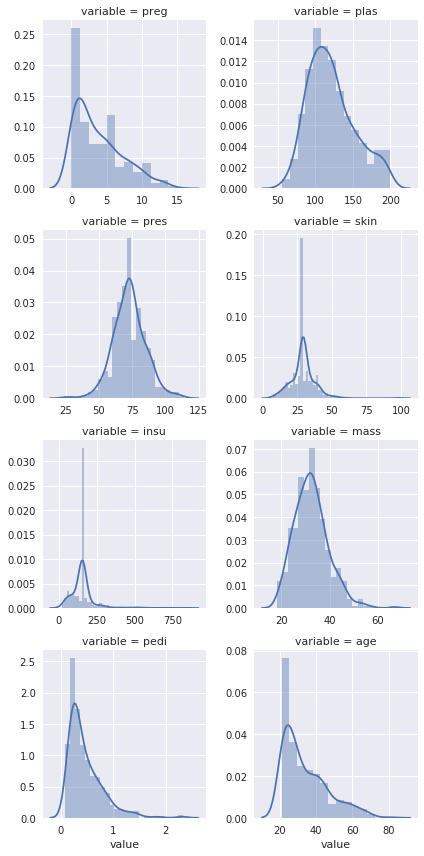

In [29]:
gMultipleHistogram(cleanDf1Train)

En el dataset wisconsin es más sencillo identificar los valores perdidos, ya que estos están representados como NA. Así, podríamos tratarlos de varias formas:
* Eliminar el caso que contenga valores perdidos: este método sería muy arriesgado ya que, si hay muchos valores perdidos, perderíamos gran parte del dataset.
* Eliminar la variable que contenga valores perdidos: este método tampoco lo vamos a usar, porque, aunque los valores NA solo aparecen en la variable 'bareNuclei', perderíamos muchos datos si eliminásemos dicha variable.
* Rellenar valores perdidos con algún valor concreto: en nuestro caso, esta será la técnica que vamos a usar, y rellenaremos los valores con la media.

Como ya hemos dicho antes, la media la sacaremos solo del conjunto de Train, y con ella rellenaremos tanto los valores perdidos del conjunto de Train, como del conjunto de Test.

In [30]:
# Calculamos el vector de medias
meansValues2 = wisconsinTraining.mean()
prueba2Train=wisconsinTraining.copy()
prueba2Test=wisconsinTest.copy()

# Ahora lo usamos para rellenar:
cleanDf2Train = prueba2Train.fillna( meansValues2 )
cleanDf2Test = prueba2Test.fillna(meansValues2)

Por último, volvemos a mostrar los histogramas de nuestras variables tras el tratamiento de los valores peridos. La única que ha cambiado ha sido la variable 'bareNuclei', ya que, como hemos dicho antes, era la única que presentaba valores NaN.

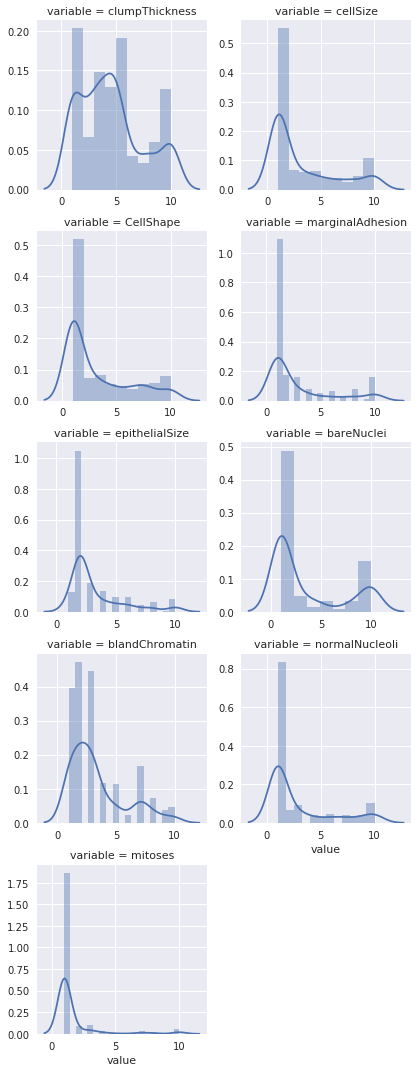

In [31]:
gMultipleHistogram(cleanDf2Train)

## 2. Aprendizaje y evaluación de un clasificador zeroR (con holdout).

Un clasificador ZeroR utiliza la clase mayoritaria para predecir la clase ante nuevos casos en el dataset. Por tanto, para implementar nuestro clasificador, debemos calcular la moda en ambos datasets, lo que nos devolverá las clases mayoritarias en ambos casos: 'tested_negative' en pima y 'benign' en el caso de wisconsin.

In [32]:
cleanDf1Train.label.mode()

0    tested_negative
Name: label, dtype: category
Categories (2, object): [tested_negative, tested_positive]

In [33]:
cleanDf2Train.label.mode()

0    benign
Name: label, dtype: category
Categories (2, object): [benign, malignant]

Primero debemos usar la función trainZeroR, que se nos proporcionaba en el guión de la práctica 1, para crear nuestro clasificador ZeroR. Con este clasificador, nuevas instancias en el dataset deberán ser predichas usando la etiqueta mayoritaria en nuestra variable clase (label). Para ello, creamos una nueva columna en el dataset llamada prediction, que albergará la predicción de la clase mayoritaria en cada caso de la base de datos.

In [34]:
# This is the outer function that should return the classifier function
def trainZeroR(trainingData):
    # We first learn the parameters, aka, the most probable class
    # Tip! get the class variable mode and take the first value
    majorClass = trainingData.label.mode()[0]# <-- COMPLETE
    
    # Now we create and return the classifier function
    def classifier( data ):
        return data.assign( prediction=majorClass ) # <-- COMPLETE
    
    return classifier

A continuación usamos la función trainAndEvalClassifier del guión de la práctica1, para entrenar el clasificador con nuestros conjuntos de Train, y validarlo con nuestros conjuntos de Test. Esta función nos devolverá una matriz de confusión con los casos, y un accuracy del modelo aprendido al enfrentarlo a los casos de Test.

In [35]:
# The star notated argument are cale varargs, and can be passed to inner functions
def trainAndEvalClassifier(classifier, trainingDf, testDf, **kwargs):
    model = classifier(trainingDf, **kwargs)
    predictedDf = model(testDf)
    tab = pd.crosstab(predictedDf['label'], predictedDf['prediction'])
    comparison = predictedDf[predictedDf['label'] == predictedDf['prediction'] ]
    accuracy = len(comparison) / len(predictedDf)
    return (tab, accuracy)

Primero con pima.

In [36]:
(tab1, accuracy1) = trainAndEvalClassifier(trainZeroR, cleanDf1Train, cleanDf1Test)

In [37]:
tab1

prediction,tested_negative
label,
tested_negative,201
tested_positive,107


In [38]:
print("Accuracy pima ZeroR:", accuracy1)

Accuracy pima ZeroR: 0.6525974025974026


Y ahora con el dataset wisconsin

In [39]:
(tab2, accuracy2) = trainAndEvalClassifier(trainZeroR, cleanDf2Train, cleanDf2Test)

In [40]:
tab2

prediction,benign
label,
benign,183
malignant,97


In [41]:
print("Accuracy wisconsin ZeroR:", accuracy2)

Accuracy wisconsin ZeroR: 0.6535714285714286


Como vemos, nuestros ZeroR's no son muy precisos. El clasificador ZeroR siempre predice la clase mayoritaria, luego todos los casos que no pertenezcan a esta, serán mal clasificados. 

El accuracy solo mide la tasa de aciertos conseguida, por lo que no tiene en cuenta las instancias mal clasificadas. Para saber si este clasificador es verdaderamente bueno, deberíamos analizar su curva ROC y el AUC, ya que esta medida tiene en cuenta tanto los aciertos como los fallos en las predicciones.

## 3. Aprendizaje y evaluación de un clasificador oneR (con holdout).

El clasificador OneR clasifica nuevas instancias basándose en los valores de una de las variables, la cual debe ser la más descriptiva o la más discriminatoria respecto a la clase.

Para implementar este clasificador usamos la función trainOneR que se nos proporcionaba (incompleta) en el guión de la práctica 1. Esta función recibe como parámetros el conjunto de Train y el número de particiones que deberá realizar para entrenar dicho conjunto.

Lo primero que hace esta función es recorrer los atributos del dataset. Para cada atributo, realiza una partición en 3 bins para poder discretizar sus valores, y después forma la matriz de confusión y calcula el error cometido en cada uno de estos bins.

Una vez hecho esto para todos los atributos del dataset, nos quedaremos con el atributo que menor error haya conseguido en sus predicciones, y guardaremos los valores asignados de la clase para cada uno de los intervalos de dicho atributo.

Por último, solo queda probar con el conjunto de Test. Para cada nueva instancia, se comprobará en qué intervalo (de los creados para el mejor atributo) cae su valor para el atributo elegido, y le asignaremos la clase que corresponda a dicho intervalo. 

In [74]:
# Complete the code when indicated with ???

# Outer learning function, hyperparameter nbins=1 is equivalent to zeroR if all attributes are continuous
def trainOneR(trainingData, nbins = 1, debug = True):
    # Debug: 
    if debug:
        print("-----------------------------------")
        print("Training OneR")
        print("-----------------------------------")
        print("attribute\terror")
    # ------------------------------------

    # Loop maximization variables
    best_attribute = ''
    best_partitions = []
    best_classes = []
    best_error =  float("inf")

    # We discretize each attribute and compute its error
    for att in trainingData.columns.values: 
        # We must ignore the class variable
        if att == 'label': continue

        # First we generate the partitions
        (attribute, bins) = pd.cut(trainingData[att], bins=3, retbins=True) #los bins son por igual anchura
        
        # The we must compute the error
        tab = pd.crosstab(attribute, trainingData['label'])
        #print(tab)
        #para cada fila calculamos su error y sumamos para obtener el error total del atributo
        error = sum( [ sum(f) - max(f) for f in tab.values ] ) 
        #print(error)

        # We can show each variable individual error
        if debug:
            print(att, "\t", error)
        # ----------------------------------------
        
        # Lastly we compare if this attribute is better than the previous local optima
        if (error < best_error):
            # If that is the case we store it as the current local optima
            best_attribute  = att
            #Pandas añade un bin más al principio al llamar a cut, por eso debemos prescindir de el 
            best_partitions = bins[1:] 
            # We must store the majority class for each interval in order to assign it
            # during classification
            #para cada intervalo, calculamos la clase mayoritaria
            best_classes = [ tab.columns[f.argmax()] for f in tab.values ] 
            best_error = error

    # Now we generate the classifier function regarding the previous parameters
    def classifier( testData ):
        # It simply assigns the majority class for each interval
        # For that we can use an auxiliar function to check which interval the current value
        # for the optimal attribute belongs to and assign the stored majority class
        def assignClass( attValue ):
            for i in range(len(best_partitions)):
                #si el valor del atributo entra dentro del intervalo establecido, 
                #le asigno la clase mayoritaria en ese intervalo
                if attValue <= best_partitions[i]: 
                    return best_classes[i]

        # Now we apply the previous function to all the instances in the dataset
        # Remember that when using map in python3 we must cast the result as list
        prediction = list(map( assignClass, testData[best_attribute] ))
        return testData.assign( prediction=prediction )
    
    print("-----------------------------------")
    print("Best Attribute: ", best_attribute)
    return classifier

A continuación usamos la función trainAndEvalClassifier del guión de la práctica1, para entrenar el clasificador con nuestros conjuntos de Train, y validarlo con los conjuntos de Test. 

Primero con pima.

In [75]:
(tab11, accuracy11) = trainAndEvalClassifier(trainOneR, cleanDf1Train, cleanDf1Test, nbins=len(cleanDf1Train.label.unique()))

-----------------------------------
Training OneR
-----------------------------------
attribute	error
label          tested_negative  tested_positive
preg                                           
(-0.015, 5.0]              234               96
(5.0, 10.0]                 58               50
(10.0, 15.0]                 7               15
153
preg 	 153
label               tested_negative  tested_positive
plas                                                
(55.857, 103.667]               133               13
(103.667, 151.333]              144               88
(151.333, 199.0]                 22               60
123
plas 	 123
label          tested_negative  tested_positive
pres                                           
(23.91, 54.0]               23                4
(54.0, 84.0]               235              126
(84.0, 114.0]               41               31
161
pres 	 161
label             tested_negative  tested_positive
skin                                              
(6.908

In [44]:
tab11

prediction,tested_negative,tested_positive
label,,
tested_negative,191,10
tested_positive,65,42


In [45]:
print("Accuracy pima OneR: ",accuracy11)

Accuracy pima OneR:  0.7564935064935064


Este accuracy es más alto que el obtenido con ZeroR, por lo que podríamos concluir que los casos se clasifican algo mejor teniendo en cuenta una de las variables del dataset. Sin embargo, no podríamos clasificar los casos en base a un solo atributo del dataset, deberíamos analizar los demás atributos para saber cuál es la clase a la que pertenecerían.

Ahora veremos los resultados con el dataset wisconsin.

In [46]:
(tab21, accuracy21) = trainAndEvalClassifier(trainOneR, cleanDf2Train, cleanDf2Test, nbins=len(cleanDf2Train.label.unique()))

-----------------------------------
Training OneR
-----------------------------------
attribute	error
clumpThickness 	 70
cellSize 	 45
CellShape 	 44
marginalAdhesion 	 71
epithelialSize 	 76
bareNuclei 	 42
blandChromatin 	 57
normalNucleoli 	 65
mitoses 	 123
-----------------------------------
Best Attribute:  bareNuclei


In [47]:
tab21

prediction,benign,malignant
label,,
benign,178,5
malignant,25,72


In [48]:
print("Accuracy wisconsin OneR: ",accuracy21)

Accuracy wisconsin OneR:  0.8928571428571429


Este accuracy es más alto que el obtenido con ZeroR, por lo que deberíamos pensar que es necesario tener en cuenta más atributos a la hora de clasificar las instancias.

### 3.1. Algunas consideraciones sobre los atributos 'plas' y 'bareNuclei'

Como hemos visto con el clasificador OneR, los mejores atributos para los dataset pima y wisconsin, respectivamente, son 'plas' y 'bareNuclei'. Al analizar sus diagramas de cajas, vemos claramente que existe una diferenciación de la clase teniendo en cuenta estos atributos, sobretodo en el dataset wisconsin usando el atributo 'bareNuclei'.

In [49]:
def gSingleBoxplot(targetdf, att):
    sns.boxplot(x='label', y=att, data=targetdf)

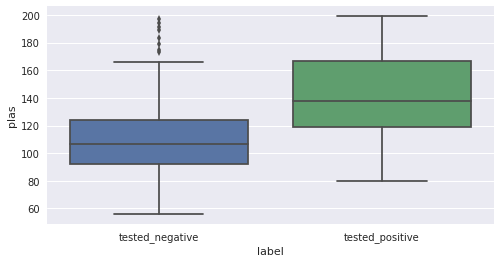

In [50]:
gSingleBoxplot(cleanDf1Train,'plas')

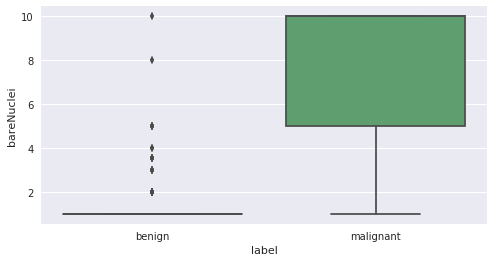

In [51]:
gSingleBoxplot(cleanDf2Train,'bareNuclei')

## 4. Aprendizaje y evaluación de un árbol de decisión (con holdout).

Los árboles de decisión nos ayudan a predecir la clase teniendo en cuenta un mayor número de atributos del dataset, mientras que en OneR solo teníamos en cuenta uno de ellos (y ninguno en el caso de ZeroR).

Para utilizar el algoritmo de este clasificador debemos usar el paquete scikit-learn, tal y como aparece en el guión de la práctica 1, para poder aprender un árbol de decisión para cada uno de nuestros dos datasets. 

In [52]:
from sklearn import tree
# Init the models(set hyperparameters)
model1 = tree.DecisionTreeClassifier(random_state=seed)
model2 = tree.DecisionTreeClassifier(random_state=seed)

Como ya venimos haciendo en procesos anteriores, esta librería necesita que nuestros conjuntos de entrenamiento provenientes de los datasets estén separados en dos conjuntos de datos: por un lado los atributos y por otro la clase.

In [53]:
features1 = cleanDf1Train.drop('label',1)
labels1 = cleanDf1Train['label']

features2 = cleanDf2Train.drop('label',1)
labels2 = cleanDf2Train['label']

A continuación, debemos aprender un modelo para cada uno de nuestros datasets usando la función fit de la librería.

In [54]:
# Use fit to learn from a configured model
classifier1 = model1.fit(features1, labels1)
classifier2 = model2.fit(features2, labels2)

Por último, usamos los conjuntos de Test para predecir la clase de cada una de las instancias, y comprobamos los resultados con sus matrices de confunsión y el accuracy obtenido en cada uno de los casos.

In [55]:
testFeatures11 = cleanDf1Test.drop('label',1)
prediction11 = classifier1.predict(testFeatures11)

testFeatures21 = cleanDf2Test.drop('label',1)
prediction21 = classifier2.predict(testFeatures21)

In [56]:
pd.crosstab(cleanDf1Test['label'], prediction11)

col_0,tested_negative,tested_positive
label,,
tested_negative,153,48
tested_positive,38,69


In [57]:
pd.crosstab(cleanDf2Test['label'], prediction21)

col_0,benign,malignant
label,,
benign,178,5
malignant,12,85


In [58]:
comparison11 = cleanDf1Test[cleanDf1Test['label'] == prediction11]
accuracy11 = len(comparison11) / len(cleanDf1Test)
print("Accuracy pima DecisionTree:", accuracy11)

Accuracy pima DecisionTree: 0.7207792207792207


Para el dataset pima, el accuracy no mejora con respecto al clasificador OneR, a pesar de que se tienen en cuenta más atributos a la hora de predecir la clase. Si quisiéramos obtener una mayor precisión en nuestras clasificaciones, tal vez deberíamos pensar en combinar distintas variables para crear otras nuevas, que nos ayuden a predecir mejor la clase en nuestro conjunto de datos.

In [59]:
comparison21 = cleanDf2Test[cleanDf2Test['label'] == prediction21]
accuracy21 = len(comparison21) / len(cleanDf2Test)
print("Accuracy wisconsin DecisionTree:", accuracy21)

Accuracy wisconsin DecisionTree: 0.9392857142857143


El accuracy obtenido para el dataset wisconsin es mejor que el obtenido en el OneR, por lo que podemos concluir que ha sido una buena decisión tener en cuenta un mayor número de atributos del dataset juntos para obtener una buena clasificación de nuestras instancias del conjunto de Test.

Sin embargo, este accuracy tan alto podría ser debido a que nuestro árbol de decisión a sobreajustado sus resultados demasiado al conjunto de Train, y que el conjunto de Test es demasiado parecido al conjunto de entrenamiento.

## 5. Consideraciones sobre el dataset PIMA

### 5.1. OneR

Como hemos visto en nuestra clasificación usando OneR, cuando validamos con nuestro conjunto de Test, el accuracy obtenido no es muy bueno (Accuracy pima OneR:  0.7564935064935064), por lo que podríamos pensar que el modelo se ha ajustado demasiado al conjunto de Train (sobreajuste). Para comprobarlo, vamos a evaluar el mismo modelo obtenido con el clasificador OneR, pero pasándole esta vez el conjunto de Train para validarlo.

In [60]:
(tab12, accuracy12) = trainAndEvalClassifier(trainOneR, cleanDf1Train, cleanDf1Train, nbins=len(cleanDf1Train.label.unique()))

-----------------------------------
Training OneR
-----------------------------------
attribute	error
preg 	 153
plas 	 123
pres 	 161
skin 	 160
insu 	 157
mass 	 158
pedi 	 161
age 	 151
-----------------------------------
Best Attribute:  plas


In [61]:
tab12

prediction,tested_negative,tested_positive
label,,
tested_negative,277,22
tested_positive,101,60


In [62]:
print("Accuracy pima OneR with Train set: ",accuracy12)

Accuracy pima OneR with Train set:  0.7326086956521739


Como ambos accuracys son muy parecidos (Accuracy pima OneR:  0.7564935064935064 y Accuracy pima OneR with Train set:  0.7326086956521739) podemos concluir que no se ha producido sobreajuste.

### 5.2. Árbol de decisión

Ahora vamos a comprobar del mismo modo si se ha producido sobreajuste a la hora de aprender el modelo para nuestro árbol de decisión. Para ello, validaremos nuestro modelo aprendido con el conjunto de Train del dataset pima, usando el mismo conjunto de Train. 

In [63]:
testFeatures12 = cleanDf1Train.drop('label',1)
prediction12 = classifier1.predict(testFeatures12)

In [64]:
pd.crosstab(cleanDf1Train['label'], prediction12)

col_0,tested_negative,tested_positive
label,,
tested_negative,299,0
tested_positive,0,161


In [65]:
comparison12 = cleanDf1Train[cleanDf1Train['label'] == prediction12]
accuracy12 = len(comparison12) / len(cleanDf1Train)
print("Accuracy pima DecisionTree with Train set:", accuracy12)

Accuracy pima DecisionTree with Train set: 1.0


Este es un caso claro de sobreajuste, ya que al pasarle el mismo conjunto de entrenamiento para validar el modelo, vemos que la tasa de acierto es del 100%, lo que quiere decir que nuestro modelo se ha ajustado demasiado a nuestro conjunto de entrenamiento. Al pasarle a este modelo el conjunto de Test, el accuracy disminuye en gran medida (Accuracy pima DecisionTree: 0.7207792207792207 y Accuracy pima DecisionTree with Train set: 1.0).

## 6. Consideraciones sobre el dataset Wisconsin

### 6.1. OneR

Para este dataset haremos la misma comparativa que hemos hecho para el dataset pima.

In [66]:
(tab22, accuracy22) = trainAndEvalClassifier(trainOneR, cleanDf2Train, cleanDf2Train, nbins=len(cleanDf2Train.label.unique()))

-----------------------------------
Training OneR
-----------------------------------
attribute	error
clumpThickness 	 70
cellSize 	 45
CellShape 	 44
marginalAdhesion 	 71
epithelialSize 	 76
bareNuclei 	 42
blandChromatin 	 57
normalNucleoli 	 65
mitoses 	 123
-----------------------------------
Best Attribute:  bareNuclei


In [67]:
tab22

prediction,benign,malignant
label,,
benign,265,10
malignant,32,112


In [68]:
print("Accuracy wisconsin OneR with Train set: ",accuracy22)

Accuracy wisconsin OneR with Train set:  0.8997613365155132


En este caso no observamos sobreajuste, ya que ambos accuracys son muy parecidos tanto al validar con el Test como con el Train (Accuracy wisconsin OneR:  0.8928571428571429 y Accuracy wisconsin OneR with Train set:  0.8997613365155132).

### 6.2. Árbol de decisión

Ahora probaremos lo mismo con el árbol de decisión.

In [69]:
testFeatures22 = cleanDf2Train.drop('label',1)
prediction22 = classifier2.predict(testFeatures22)

In [70]:
pd.crosstab(cleanDf2Train['label'], prediction22)

col_0,benign,malignant
label,,
benign,275,0
malignant,0,144


In [71]:
comparison22 = cleanDf2Train[cleanDf2Train['label'] == prediction22]
accuracy22 = len(comparison22) / len(cleanDf2Train)
print("Accuracy wisconsin DecisionTree with Train set:", accuracy22)

Accuracy wisconsin DecisionTree with Train set: 1.0


Aunque el accuracy vuelve a ser del 100% como en el caso de pima con el Train, en este caso el accuracy de wisconsin usando el conjunto de Test es muy parecido al obtenido ahora usando el conjunto de Train (Accuracy wisconsin DecisionTree: 0.9392857142857143 y Accuracy wisconsin DecisionTree with Train set: 1.0), por lo que podemos decir que no se observa sobreajuste en este dataset, ni con árbol de decisión ni con OneR.